# Plotting configurations

In [20]:
from util.create_bins import create_bins_clustering, create_bins_geometric_sampling, create_bins_pca_projection, create_bins_clustering_efficient
import pandas as pd
import numpy as np

In [21]:
dataset = 'music'

data = pd.read_csv(f"../datasets/{dataset}/preprocessed_{dataset}.csv")

In [22]:
from scipy.spatial.distance import pdist

def calculate_partitioning_measure(current_partition):
    result = 0

    for partition in current_partition:
        result = result + (1 / len(partition))

    return result

def calculate_max_distance(feature_data_with_bins):
    max_value = 0
    max_pdist_handle = 50000

    for index, bin_df in feature_data_with_bins.groupby("bin"):
        if len(bin_df) > 1:
            features = bin_df.drop("bin", axis=1).to_numpy()

            if len(features) > max_pdist_handle:
                features = features[np.random.choice(features.shape[0], size=max_pdist_handle, replace=False)]

            distances = pdist(features, metric='euclidean')

            max_distance = distances.max()

            if max_value < max_distance:
                max_value = max_distance

    return max_value

def get_history_binning_method(binning_fn, feature_data):
    feature_data["bin"] = binning_fn()

    current_partition = []

    for group, group_df in feature_data.groupby("bin"):
        indices = group_df.index.to_numpy()
        current_partition.append(indices)

    partitioning_measure = calculate_partitioning_measure(current_partition)
    max_distance = calculate_max_distance(feature_data)

    return (partitioning_measure, max_distance)


In [23]:
sampled_data = data

feature_data = sampled_data.drop("label", axis=1)

kmeans_feature_data = feature_data.copy()
clustering_feature_data = feature_data.copy()
geometric_feature_data = feature_data.copy()
pca_feature_data = feature_data.copy()

In [24]:
from sklearn.cluster import KMeans

k = 5

def partition_feature_space_kmeans(k, feature_data):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feature_data)

    return kmeans.labels_

binning_fn = lambda: partition_feature_space_kmeans(5, kmeans_feature_data) 

partitioning_measure, max_distance = get_history_binning_method(binning_fn, feature_data=kmeans_feature_data.copy())
print(partitioning_measure, max_distance)

0.027503235790906005 3.2751686619228355


In [25]:
clustering_history = []
clustering_configs = []

cutoffs = list(np.arange(1, 25, 2)) + list(np.arange(25, 75, 5))

for cutoff in cutoffs:
    print(cutoff)
    clustering_configs.append(cutoff)
    
    binning_fn = lambda: create_bins_clustering_efficient(clustering_feature_data, linkage_method='ward', partitioning_measure_cutoff=cutoff) 
    
    partitioning_measure, max_distance = get_history_binning_method(binning_fn,feature_data=clustering_feature_data.copy())
    clustering_history.append((partitioning_measure, max_distance))

1
3
5
7
9
11
13
15
17
19
21
23
25
30
35
40
45
50
55
60
65
70


In [26]:
pca_history = []

number_of_bins_configs = np.arange(2, 15, 4)
number_pca_components = np.arange(1, 5)

for number_of_bins_per_dimension in number_of_bins_configs:
    for number_pca_comp in number_pca_components:
        print(number_pca_comp, number_of_bins_per_dimension)
        binning_fn = lambda: create_bins_pca_projection(pca_feature_data, number_pca_components=number_pca_comp, number_bins_per_reduced_dimension=number_of_bins_per_dimension) 
        print('calculate history')
        pca_history.append(get_history_binning_method(binning_fn, feature_data=pca_feature_data.copy()))

1 2
calculate history
explained variance 0.454987643006385
2 2
calculate history
explained variance 0.7084283861359095
3 2
calculate history
explained variance 0.7654279844762658
4 2
calculate history
explained variance 0.8158483807047797
1 6
calculate history
explained variance 0.454987643006385
2 6
calculate history
explained variance 0.7084283861359095
3 6
calculate history
explained variance 0.7654279844762658
4 6
calculate history
explained variance 0.8158483807047797
1 10
calculate history
explained variance 0.454987643006385
2 10
calculate history
explained variance 0.7084283861359095
3 10
calculate history
explained variance 0.7654279844762658
4 10
calculate history
explained variance 0.8158483807047797
1 14
calculate history
explained variance 0.454987643006385
2 14
calculate history
explained variance 0.7084283861359095
3 14
calculate history
explained variance 0.7654279844762658
4 14
calculate history
explained variance 0.8158483807047797


In [27]:
geometric_history = []

number_of_bins_configs = np.arange(2, 15, 3)

for number_of_bins_per_dimension in number_of_bins_configs:
    print(number_of_bins_per_dimension)
    binning_fn = lambda: create_bins_geometric_sampling(geometric_feature_data, number_of_bins_per_dimension=number_of_bins_per_dimension) 
    geometric_history.append(get_history_binning_method(binning_fn, feature_data=geometric_feature_data.copy()))    

2
5
8
11
14


In [28]:
distances_clustering_efficient = [x[1] for x in clustering_history]
partitioning_measure_clustering_efficient = [x[0] for x in clustering_history]

distances_geometric = [x[1] for x in geometric_history]
partitioning_measure_geometric = [x[0] for x in geometric_history]

distances_pca = [x[1] for x in pca_history]
partitioning_measure_pca = [x[0] for x in pca_history]

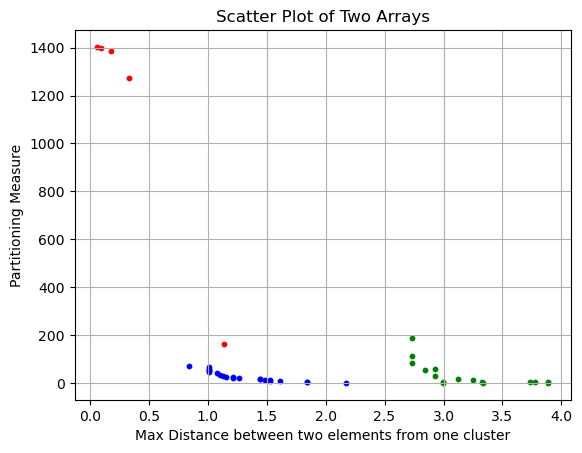

In [29]:
import matplotlib.pyplot as plt

plt.scatter(distances_clustering_efficient, partitioning_measure_clustering_efficient, color='blue', marker='o', s=10)
plt.scatter(distances_geometric, partitioning_measure_geometric, color='red', marker='o', s=10)
plt.scatter(distances_pca, partitioning_measure_pca, color='green', marker='o', s=10)

plt.title("Scatter Plot of Two Arrays")
plt.xlabel("Max Distance between two elements from one cluster")
plt.ylabel("Partitioning Measure")

plt.grid(True)
plt.show()

In [30]:
xlim = 3
ylim = 100

[<matplotlib.collections.PathCollection object at 0x0000022919C1A010>, <matplotlib.collections.PathCollection object at 0x000002291A2B2D90>, <matplotlib.collections.PathCollection object at 0x000002291A2BE490>] ['hierarchical clustering', 'grid-based partitioning', 'projected partitioning']
[] []


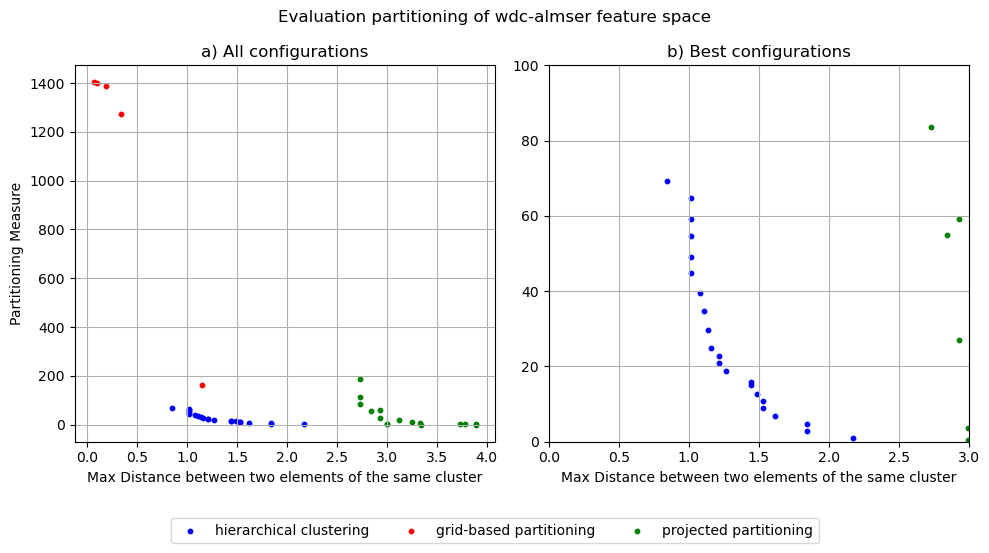

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax1, ax2 = axs

plt.tight_layout()

ax1.scatter(distances_clustering_efficient, partitioning_measure_clustering_efficient, color='blue', marker='o', s=10, label='hierarchical clustering')
ax1.scatter(distances_geometric, partitioning_measure_geometric, color='red', marker='o', s=10, label='grid-based partitioning')
ax1.scatter(distances_pca, partitioning_measure_pca, color='green', marker='o', s=10, label='projected partitioning')

ax1.set_title("a) All configurations")
ax1.set_xlabel("Max Distance between two elements of the same cluster")
ax1.set_ylabel("Partitioning Measure")

ax2.scatter(distances_clustering_efficient, partitioning_measure_clustering_efficient, color='blue', marker='o', s=10)
ax2.scatter(distances_geometric, partitioning_measure_geometric, color='red', marker='o', s=10)
ax2.scatter(distances_pca, partitioning_measure_pca, color='green', marker='o', s=10)

ax2.set_title("b) Best configurations")
ax2.set_xlabel("Max Distance between two elements of the same cluster")
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

ax1.grid(True)
ax2.grid(True)

handles = []
all_labels = []

axs = axs.flatten()

for i, ax in enumerate(axs):

    h, l = ax.get_legend_handles_labels()
    print(h, l)
    handles.extend(h)
    all_labels.extend(l)
    if i == 1:
        break

fig.legend(handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1),
           ncol=3)

plt.suptitle("Evaluation partitioning of wdc-almser feature space")
plt.tight_layout()
plt.show()


In [32]:
distances_clustering_efficient = [x[1] for x in clustering_history]
partitioning_measure_clustering_efficient = [x[0] for x in clustering_history]

for index, (partitioning_measure, distance) in enumerate(clustering_history):
    if partitioning_measure < ylim and distance < xlim:
        print('---------------')
        print(f'cutoff = {clustering_configs[index]}')
        print(f'distance = {distance}')
        print(f'partitioning measure = {partitioning_measure}')

---------------
cutoff = 1
distance = 2.169377523850973
partitioning measure = 0.9931059979885765
---------------
cutoff = 3
distance = 1.841253444875582
partitioning measure = 2.908560558272625
---------------
cutoff = 5
distance = 1.841253444875582
partitioning measure = 4.642463080566371
---------------
cutoff = 7
distance = 1.6160120558661717
partitioning measure = 6.787374879293957
---------------
cutoff = 9
distance = 1.5293303608284396
partitioning measure = 8.916973034510226
---------------
cutoff = 11
distance = 1.5293303608284396
partitioning measure = 10.778344842956336
---------------
cutoff = 13
distance = 1.4850873309371495
partitioning measure = 12.593711877595817
---------------
cutoff = 15
distance = 1.4421840336362803
partitioning measure = 14.92256567048362
---------------
cutoff = 17
distance = 1.4421840336362803
partitioning measure = 15.98036465512471
---------------
cutoff = 19
distance = 1.2639178021699278
partitioning measure = 18.82783934503749
---------------